# XGBoost, LightGBM 을 이용

산탄데르 은행이 캐글에 경연을 의뢰한 데이터로 "피처이름"은 모두 익명, "클래스 레이블 명" 은 TARGET이며, 이 값이 0이면 만족, 1이면 불만족하는 고객이다. <br>
이때, 레이블의 값이 대부분 만족이고, 불만족인 데이터는 일부이기 때문에 모델의 성능 평가는 "정확도" 가 아닌 ROC-AUC을 이용한다.

# 1. 데이터 전처리

## - 데이터 로드 및 확인

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

cust_df = pd.read_csv("/workspace/ML_With_GPU/ML_Data/Santander_Customer/train.csv", encoding='latin-1')
print('dataset shape : ', cust_df.shape)
cust_df.head(3)

dataset shape :  (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


클래스 값 칼럼을 포함한 개수가 371개임을 확인할 수 있다.

## - feature 에 대한 더 자세한 정보 확인

In [36]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


dtype에서 확인할 수 있듯, Null값은 없다.

## - Target의 분포 확인하기

In [37]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('불만족의 비율 : {0:.2f}'.format((unsatisfied_cnt/total_cnt)) )

0    73012
1     3008
Name: TARGET, dtype: int64
불만족의 비율 : 0.04


## - 각 피처의 값 분포 확인하기

In [38]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


### * var3
var3의 최소값의 경우 -999999인 것을 확인할 수 있는데. 이것은 아마 NaN이나 특정 예외값을 변환한 값일 것이므로 이를 한번 더 확인해보자.

In [63]:
print(cust_df['var3'].value_counts().sort_values(ascending=False)[:10])

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64


-999999는 다른 값에 비해 편차가 너무 심하다는 것을 알 수 있다. 따라서 이를 가장 많은 값인 2로 치환하도록 하겠다.

In [66]:
cust_df['var3'].replace(-999999, 2, inplace=True)
print(cust_df['var3'].value_counts().sort_values(ascending=False)[:10])

2     74281
8       138
9       110
3       108
1       105
13       98
7        97
4        86
12       85
6        82
Name: var3, dtype: int64


### * ID

ID는 단순 식별자에 불과하므로 드롭하겠다.

In [68]:
cust_df.drop('ID', axis=1, inplace=True)

## - 피쳐세트와 클래스 데이터 셋 분리

In [70]:
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처데이터 셋 shape : {0}'.format(X_features.shape))
print('클래스데이터 셋 shape : {0}'.format(y_labels.shape))

피처데이터 셋 shape : (76020, 369)
클래스데이터 셋 shape : (76020,)


## - 학습/테스트 데이터 분리

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0, stratify = y_labels)

train_cnt = y_train.count()
test_cnt = y_test.count()

#학습/테스트 셋 shape
print('학습 셋 shape : {0}, 테스트 셋 : {1}\n'.format(X_train.shape, X_test.shape))

#학습/테스트 셋 레이블 값 비율
print('학습 셋 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n테스트 셋 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 셋 shape : (60816, 369), 테스트 셋 : (15204, 369)

학습 셋 레이블 값 분포 비율
0    0.960438
1    0.039562
Name: TARGET, dtype: float64

테스트 셋 레이블 값 분포 비율
0    0.960405
1    0.039595
Name: TARGET, dtype: float64


stratify 옵션을 통해 학습 셋과 테스트셋의 레이블 값 분포를 동일하게 하였다.

# 2. XGBoost 모델 학습과 하이퍼 파라미터 튜닝

## - 학습 및 예측 수행

평가 데이터 셋인 eval_set에는 test 데이터를 넣어주기로 한다. 이때 원래는 테스트 데이터를 넣으면 과적합의 가능성을 증가시켜 원래는 crossvalidation 셋을 따로 만들어 넣어주어야하는데, 데이터의 양이 적기 때문에 여기선 그냥 테스트 데이터를 넣어주기로 한다.

In [78]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc', eval_set=[(X_test, y_test)], verbose=True)

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC-AUC : {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.79283
[1]	validation_0-auc:0.80737
[2]	validation_0-auc:0.81021
[3]	validation_0-auc:0.81287
[4]	validation_0-auc:0.81469
[5]	validation_0-auc:0.81860
[6]	validation_0-auc:0.81977
[7]	validation_0-auc:0.82034
[8]	validation_0-auc:0.82147
[9]	validation_0-auc:0.82301
[10]	validation_0-auc:0.82379
[11]	validation_0-auc:0.82456
[12]	validation_0-auc:0.82401
[13]	validation_0-auc:0.82467
[14]	validation_0-auc:0.82508
[15]	validation_0-auc:0.82379
[16]	validation_0-auc:0.82457
[17]	validation_0-auc:0.82453
[18]	validation_0-auc:0.82354
[19]	validation_0-auc:0.82328
[20]	validation_0-auc:0.82305
[21]	validation_0-auc:0.82305
[22]	validation_0-auc:0.82287
[23]	validation_0-auc:0.82256
[24]	validation_0-auc:0.82237
[25]	validation_0-auc:0.82237
[26]	validation_0-auc:0.82248
[27]	validation_0-auc:0.82199
[28]	validation_0-auc:0.82157
[29]	validation_0-auc:0.82106
[30]	validation_0-auc:0.82075
[31]	validation_0-auc:0.82011
[32]	validation_0-auc:0.82001
[33]	validation_0-au

## - 최적의 하이퍼 파라미터 찾기

In [ ]:
from sklearn.model_selection import GridSearchCV

#수행 속도 향상을 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {
    'max_depth' : [5, 7],
    'min_child_weight' : [1, 3],
    'colsample_bytree' : [0.5, 0.75]
}

gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set = [(X_test, y_test)], verbose=False)

print('GridSearchCV 최적 파라미터 : ', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

시간이 오래 걸리는 관계로... 책에 나온 결과로 대체한다.<br>
GridSearchCV 최적 파라미터 : {'colsample_bytree' : 0.75, 'max_depth' : 7, 'min_child_weight' : 1}<br>
ROC AUC : 0.8448

### * 최적의 하이퍼 파라미터 값을 취하고, n_estimators = 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함

In [81]:
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_metric='auc', eval_set=[(X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79358
[1]	validation_0-auc:0.79575
[2]	validation_0-auc:0.79775
[3]	validation_0-auc:0.80090
[4]	validation_0-auc:0.80287
[5]	validation_0-auc:0.80310
[6]	validation_0-auc:0.80394
[7]	validation_0-auc:0.80276
[8]	validation_0-auc:0.80585
[9]	validation_0-auc:0.80658
[10]	validation_0-auc:0.80913
[11]	validation_0-auc:0.80914
[12]	validation_0-auc:0.80953
[13]	validation_0-auc:0.80934
[14]	validation_0-auc:0.81043
[15]	validation_0-auc:0.80912
[16]	validation_0-auc:0.81030
[17]	validation_0-auc:0.81063
[18]	validation_0-auc:0.81091
[19]	validation_0-auc:0.81160
[20]	validation_0-auc:0.81145
[21]	validation_0-auc:0.81232
[22]	validation_0-auc:0.81231
[23]	validation_0-auc:0.81393
[24]	validation_0-auc:0.81398
[25]	validation_0-auc:0.81390
[26]	validation_0-auc:0.81439
[27]	validation_0-auc:0.81394
[28]	validation_0-auc:0.81328
[29]	validation_0-auc:0.81367
[30]	validation_0-auc:0.81340
[31]	validation_0-auc:0.81341
[32]	validation_0-auc:0.81375
[33]	validation_0-au

위 결과는 이 데이터셋에서 최적의 파라미터라고 할 수 없으므로... 전 결과보다 결과가 안좋아진 것을 이해하고 넘어가자..

## - 각 피처의 중요도 시각화

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

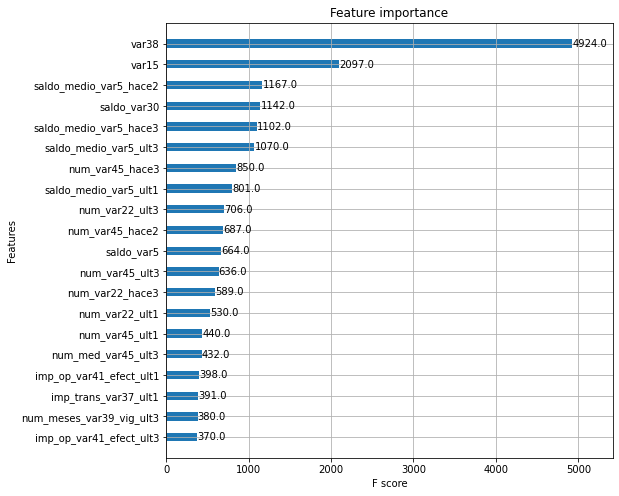

In [88]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(8,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

# 3. LightGBM 모델 학습과 하이퍼 파라미터 튜닝

## - 학습 및 예측 수행

In [90]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

lgbm_clf = LGBMClassifier(n_estimators=500, random_state=156)

lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc', eval_set=[(X_test, y_test)], verbose=False)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC-AUC : {0:.4f}'.format(lgbm_roc_score))

/usr/local/lib/python3.8/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


ROC-AUC : 0.8239


## - 최적의 하이퍼 파라미터 찾기

In [95]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

#수행 속도 향상을 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {
    'num_leaves' : [32, 64],
    'max_depth' : [128, 160],
    'min_child_weight' : [60, 100],
    'subsample' : [0.8, 1]
}

gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set = [(X_test, y_test)], verbose=False)

print('GridSearchCV 최적 파라미터 : ', gridcv.best_params_)

lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC : {0:.4f}'.format(lgbm_roc_score))

GridSearchCV 최적 파라미터 :  {'max_depth': 128, 'min_child_weight': 60, 'num_leaves': 32, 'subsample': 0.8}
ROC AUC : 0.8250


## - 최적의 하이퍼 파라미터를 가진 estimator로 재학습 미 재예측(n_estimator=1000으로 올려서 적용)

In [96]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, subsample=0.8, min_child_samples=100, max_depth=128)

lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc', eval_set=[(X_test, y_test)], verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC-AUC : {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.796283	valid_0's binary_logloss: 0.159424
[2]	valid_0's auc: 0.803289	valid_0's binary_logloss: 0.154921
[3]	valid_0's auc: 0.807301	valid_0's binary_logloss: 0.1518
[4]	valid_0's auc: 0.811102	valid_0's binary_logloss: 0.149384
[5]	valid_0's auc: 0.817613	valid_0's binary_logloss: 0.147338
[6]	valid_0's auc: 0.819807	valid_0's binary_logloss: 0.145735
[7]	valid_0's auc: 0.820399	valid_0's binary_logloss: 0.1445
[8]	valid_0's auc: 0.820003	valid_0's binary_logloss: 0.143404
[9]	valid_0's auc: 0.821257	valid_0's binary_logloss: 0.142464
[10]	valid_0's auc: 0.820964	valid_0's binary_logloss: 0.141718
[11]	valid_0's auc: 0.821671	valid_0's binary_logloss: 0.14109
[12]	valid_0's auc: 0.822687	valid_0's binary_logloss: 0.140595
[13]	valid_0's auc: 0.822748	valid_0's binary_logloss: 0.140177
[14]	valid_0's auc: 0.823109	valid_0's binary_logloss: 0.139739
[15]	valid_0's auc: 0.822756	valid_0's binary_logloss: 0.139486
[16]	valid_0's auc: 0.822894	valid_0's binary_logloss:

n_estimator를 1000으로 올려서 학습시켰더니, auc 값이 증가한 것을 확인할 수 있으므로 미약하지만 성능개선이 된 것을 확인할 수 있다.